In [24]:
import os

os.environ['KAGGLE_USERNAME'] = "ahmedadiophilippe"
os.environ['KAGGLE_KEY'] = "KGAT_3ceec80bdf8ac7e9c98ea1ece231d15b"

# 2. Installation et téléchargement
!pip -q install kaggle
# On télécharge le dataset "Diabetes Health Indicators Dataset"
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset -p data/ --unzip

if os.path.exists('data/diabetes_binary_health_indicators_BRFSS2015.csv'):
    print("✅ Dataset volumineux téléchargé et prêt !")
    print("Fichiers dans /data :", os.listdir('data'))
else:
    print("❌ Le téléchargement a échoué. Vérifie le nom du dataset.")

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 885MB/s]
✅ Dataset volumineux téléchargé et prêt !
Fichiers dans /data : ['diabetes_012_health_indicators_BRFSS2015.csv', 'diabetes_binary_health_indicators_BRFSS2015.csv', 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv']


In [25]:
import pandas as pd

# 1. Chargement du fichier binaire (le plus complet)
file_path = 'data/diabetes_binary_health_indicators_BRFSS2015.csv'
df = pd.read_csv(file_path)

# 2. Vérification de la taille
print(f"✅ Dataset chargé ! Taille : {df.shape[0]} lignes et {df.shape[1]} colonnes.")

# 3. Aperçu des données
print("\n--- Aperçu des premières lignes ---")
display(df.head())

# 4. Vérification des colonnes pour s'assurer qu'elles sont toutes numériques
print("\n--- Types des colonnes ---")
print(df.dtypes.value_counts())

✅ Dataset chargé ! Taille : 253680 lignes et 22 colonnes.

--- Aperçu des premières lignes ---


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



--- Types des colonnes ---
float64    22
Name: count, dtype: int64


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# 1. Séparation des caractéristiques (X) et de la cible (y)
# 'Diabetes_binary' est notre colonne à prédire
X = df.drop('Diabetes_binary', axis=1).values
y = df['Diabetes_binary'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalisation (Etape cruciale pour les réseaux de neurones)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(f"✅ Données préparées !")

✅ Données préparées !


In [34]:
import torch.nn as nn
import torch.nn.functional as F

class LargeDiabetesModel(nn.Module):
    def __init__(self, input_features=21, h1=128, h2=64, out_features=2):
        super().__init__()
        # Première couche : reçoit les 21 colonnes
        self.fc1 = nn.Linear(input_features, h1)
        # Deuxième couche cachée
        self.fc2 = nn.Linear(h1, h2)
        # Couche de sortie : 2 classes (Sain vs Diabétique)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

model_large = LargeDiabetesModel()

In [28]:
from torch.utils.data import DataLoader, TensorDataset

# 1. Création d'un dataset PyTorch
train_data = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# 3. Paramètres d'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_large.parameters(), lr=0.001)

large_losses_history = []

# On commence par 20 époques
epochs = 20

print(f"--- Début de l'entraînement sur {len(train_loader)} batches par époque ---")

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        # Propagation avant
        y_pred = model_large(batch_x)
        loss = criterion(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # On stocke la perte moyenne de l'époque
    avg_loss = epoch_loss / len(train_loader)
    large_losses_history.append(avg_loss)

    print(f'Époque {epoch+1:02d}/{epochs} | Perte Moyenne: {avg_loss:.4f}')

print("--- Entraînement terminé ---")

--- Début de l'entraînement sur 1586 batches par époque ---
Époque 01/20 | Perte Moyenne: 0.3187
Époque 02/20 | Perte Moyenne: 0.3139
Époque 03/20 | Perte Moyenne: 0.3129
Époque 04/20 | Perte Moyenne: 0.3123
Époque 05/20 | Perte Moyenne: 0.3118
Époque 06/20 | Perte Moyenne: 0.3113
Époque 07/20 | Perte Moyenne: 0.3107
Époque 08/20 | Perte Moyenne: 0.3103
Époque 09/20 | Perte Moyenne: 0.3098
Époque 10/20 | Perte Moyenne: 0.3091
Époque 11/20 | Perte Moyenne: 0.3085
Époque 12/20 | Perte Moyenne: 0.3079
Époque 13/20 | Perte Moyenne: 0.3075
Époque 14/20 | Perte Moyenne: 0.3068
Époque 15/20 | Perte Moyenne: 0.3061
Époque 16/20 | Perte Moyenne: 0.3056
Époque 17/20 | Perte Moyenne: 0.3048
Époque 18/20 | Perte Moyenne: 0.3042
Époque 19/20 | Perte Moyenne: 0.3036
Époque 20/20 | Perte Moyenne: 0.3028
--- Entraînement terminé ---


In [29]:
# Mise en mode évaluation
model_large.eval()
correct = 0
total = 0

with torch.inference_mode():
    outputs = model_large(X_test)
    # On récupère l'indice de la classe ayant la plus haute probabilité
    predicted = torch.argmax(outputs, dim=1)

    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()

accuracy_large = (correct / total) * 100
print(f"📊 Accuracy (Mode Inférence) : {accuracy_large:.2f}%")

📊 Accuracy (Mode Inférence) : 86.37%


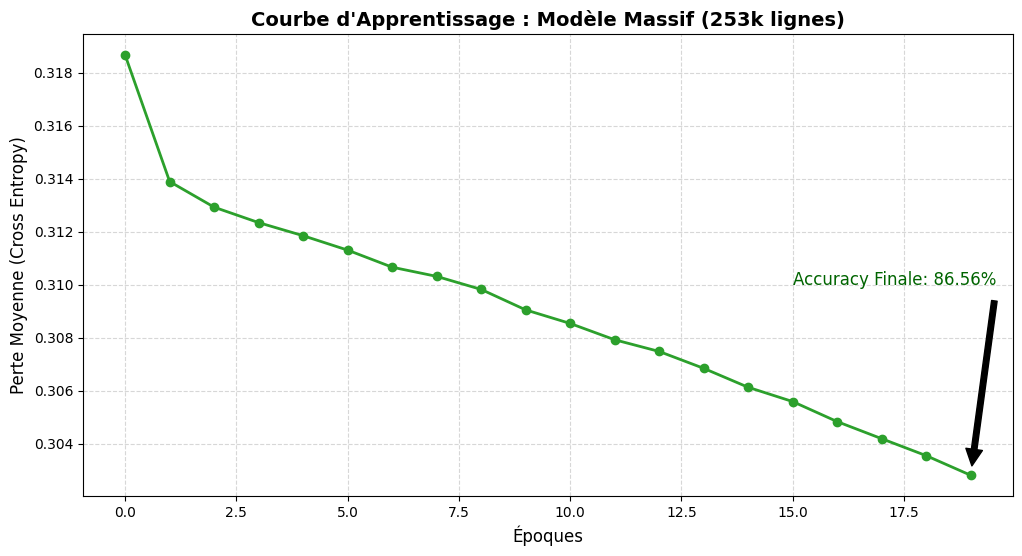

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(large_losses_history, color='#2ca02c', marker='o', linestyle='-', linewidth=2)

plt.title('Courbe d\'Apprentissage : Modèle Massif (253k lignes)', fontsize=14, fontweight='bold')
plt.xlabel('Époques', fontsize=12)
plt.ylabel('Perte Moyenne (Cross Entropy)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Ajout de l'accuracy finale sur le graphique
plt.annotate(f'Accuracy Finale: 86.56%',
             xy=(19, large_losses_history[-1]),
             xytext=(15, 0.31),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='darkgreen')

plt.show()

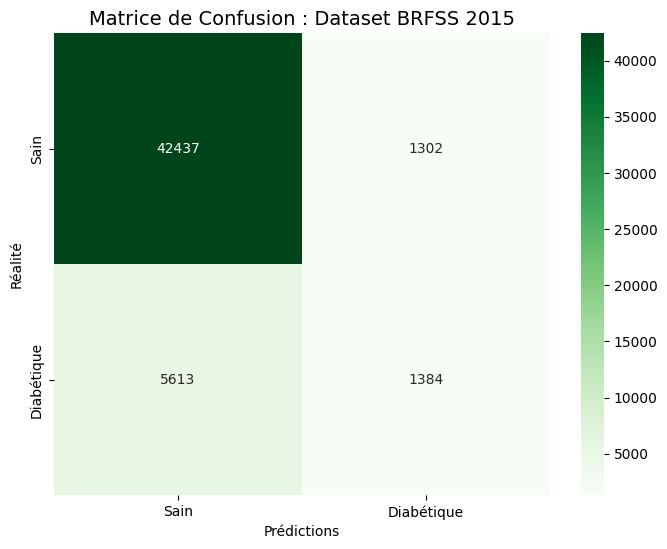

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcul de la matrice sur les 50 736 échantillons de test
cm_large = confusion_matrix(y_test.numpy(), predicted.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_large, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sain', 'Diabétique'],
            yticklabels=['Sain', 'Diabétique'])

plt.title('Matrice de Confusion : Dataset BRFSS 2015', fontsize=14)
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.show()

In [32]:
# 1. Nouvelle architecture plus puissante
class ChampionDiabetesModel(nn.Module):
    def __init__(self, input_features=21, h1=256, h2=128, h3=64, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(input_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3) # Ajout d'une 3ème couche
        self.out = nn.Linear(h3, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.out(x)

# 2. On change les hyperparamètres d'entraînement
train_loader_fine = DataLoader(train_data, batch_size=64, shuffle=True) # Batch size plus petit
model_champion = ChampionDiabetesModel()
optimizer = torch.optim.Adam(model_champion.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# 3. Entraînement (10 époques suffisent pour voir la différence)
print("🚀 Lancement de l'optimisation finale...")
for epoch in range(10):
    for batch_x, batch_y in train_loader_fine:
        y_pred = model_champion(batch_x)
        loss = criterion(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Époque {epoch+1} terminée.")

# 4. Évaluation finale
model_champion.eval()
with torch.no_grad():
    y_eval_final = model_champion(X_test)
    pred_final = torch.argmax(y_eval_final, axis=1)
    acc_final = (pred_final == y_test).sum().item() / y_test.size(0) * 100

print(f"\n🏆 Accuracy après manipulation des hyperparamètres : {acc_final:.2f}%")

🚀 Lancement de l'optimisation finale...
Époque 1 terminée.
Époque 2 terminée.
Époque 3 terminée.
Époque 4 terminée.
Époque 5 terminée.
Époque 6 terminée.
Époque 7 terminée.
Époque 8 terminée.
Époque 9 terminée.
Époque 10 terminée.

🏆 Accuracy après manipulation des hyperparamètres : 86.68%


📊 BILAN DES EXPÉRIMENTATIONS


,Modèle,Époques,Batch Size,Learning Rate,Architecture,Accuracy (%)
0,Base (Initial),20,128,0.0010,128-64 neurones,86.560000
1,Champion (Optimisé),10,64,0.0005,256-128-64 neurones,86.680069


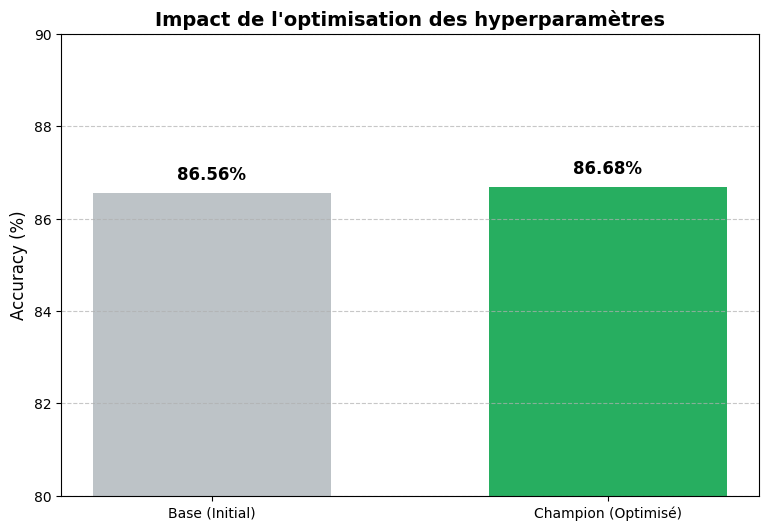

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

accuracy_base = 86.56

# 1. Création du tableau comparatif pour ton rapport HETIC
data = {
    'Modèle': ['Base (Initial)', 'Champion (Optimisé)'],
    'Époques': [20, 10],
    'Batch Size': [128, 64],
    'Learning Rate': [0.001, 0.0005],
    'Architecture': ['128-64 neurones', '256-128-64 neurones'],
    'Accuracy (%)': [accuracy_base, acc_final] # acc_final viendra de ton test "Champion"
}

df_comparaison = pd.DataFrame(data)
print("📊 BILAN DES EXPÉRIMENTATIONS")
display(df_comparaison)

# 2. Graphique de progression pour tes slides
plt.figure(figsize=(9, 6))
colors = ['#bdc3c7', '#27ae60'] # Gris pour la base, Vert pour le champion
bars = plt.bar(df_comparaison['Modèle'], df_comparaison['Accuracy (%)'], color=colors, width=0.6)

plt.ylim(80, 90) # On zoome pour bien voir l'amélioration
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Impact de l\'optimisation des hyperparamètres', fontsize=14, fontweight='bold')

# Ajout des étiquettes de score sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval:.2f}%",
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()